# 0.Requirements

## 0.1 Installation

In [ ]:
%%capture
!pip install bertopic

In [65]:
%%capture
!pip install pyLDAvis

## 0.2 Data

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


**The dataset used here is available at** https://drive.google.com/drive/folders/1ci8jsTFduo-ZPQeBnP4o2yISqRvSQZH3?usp=sharing

In [ ]:
!cp ./drive/MyDrive/Graduate\ Study/MSAI/AI6127/Project/dataset/personality.csv.zip .

In [ ]:
!unzip personality.csv.zip

Archive:  personality.csv.zip
  inflating: personality.csv         


# 1. BERTopic

## 1.0 Data

In [ ]:
import umap
import pandas as pd
import numpy as np
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

n_topics=30

In [ ]:
df = pd.read_csv("personality.csv")
chat_df = df[['chat']]
chat_df['chat'] = chat_df['chat'].apply(lambda row: row.split('\n'))
chat_df = chat_df.explode('chat')
chat_df = chat_df[chat_df.chat != '']
chat_df['length'] = chat_df.chat.apply(lambda x: len(x.split(' ')))

In [ ]:
chat_df.describe()

,length
count,131438.000000
mean,11.674014
std,4.045545
min,1.000000
25%,8.000000
50%,12.000000
75%,15.000000
max,60.000000


In [ ]:
chat_df = chat_df[chat_df.length>8]

In [ ]:
chat_df.describe()

,length
count,96164.000000
mean,13.485868
std,3.106279
min,9.000000
25%,11.000000
50%,13.000000
75%,16.000000
max,60.000000


## 1.1 Model

In [ ]:
sentence_model = SentenceTransformer("all-mpnet-base-v2", device='cuda')
embeddings = sentence_model.encode(chat_df['chat'].to_list())

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/571 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/438M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/239 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/363 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
chat_df['embeddings'] = embeddings.tolist()
chat_df['embeddings'] = chat_df['embeddings'].apply(np.array)

In [42]:
calculate_probabilities=True
umap_model = umap.UMAP(n_neighbors=15, n_components=5, min_dist=0.0, metric='cosine', low_memory=False, random_state=42)
topic_model1 =  BERTopic(verbose=True, n_gram_range=(1,1), calculate_probabilities=calculate_probabilities, umap_model=umap_model, nr_topics=n_topics)
topics1, _ = topic_model1.fit_transform(chat_df['chat'].to_list(), embeddings=np.array(chat_df['embeddings'].tolist()))

2022-04-21 09:47:00,068 - BERTopic - Reduced dimensionality with UMAP
2022-04-21 11:30:10,055 - BERTopic - Clustered UMAP embeddings with HDBSCAN
2022-04-21 11:30:23,237 - BERTopic - Reduced number of topics from 939 to 31


In [45]:
chat_df['topic'] = topics1 # 31 topics including -1 as noise

In [46]:
chat_df

,chat,length,embeddings,topic
0,"hi , how are you doing ? i am getting ready to...",21,"[0.02563648112118244, -0.021599765866994858, 0...",-1
1,you must be very fast . hunting is one of my f...,14,"[0.025687944144010544, 0.0473664253950119, -0....",-1
2,i am ! for my hobby i like to do canning or so...,15,"[-0.029020629823207855, 0.023020433261990547, ...",-1
3,i also remodel homes when i am not out bow hun...,12,"[0.0021820140536874533, 0.10070335865020752, -...",-1
4,that is neat . when i was in high school i pla...,17,"[-0.07846943289041519, -0.03638697415590286, -...",-1
...,...,...,...,...
96159,wow me too . my favorite author is cassandra c...,14,"[-0.02023237943649292, -0.011527586728334427, ...",7
96160,i love reading but hated wearing glasses when ...,12,"[-0.037287697196006775, 0.03709711134433746, -...",-1
96161,yes i used to as well but now i wear contacts ...,12,"[-0.05410580709576607, -0.015464314259588718, ...",-1
96162,i had a pair of glasses with green frames when...,13,"[-0.016246143728494644, 0.042808011174201965, ...",-1


In [54]:
topic_info = topic_model1.get_topic_info()
topic_info['Rep_docs'] = topic_info['Topic'].apply(lambda x: topic_model1.get_representative_docs(x)[:3] if x!=-1 else "")
topic_info

,Topic,Count,Name,Rep_docs
0,-1,69237,-1_you_to_do_my,
1,0,2501,0_car_drive_cars_truck,[maybe but i think a corvette would make it al...
2,1,1913,1_doing_how_are_am,[i am upset that my car is not working but i a...
3,2,1659,2_music_country_listening_listen,[too bad the beatles are not around anymore . ...
4,3,1304,3_cold_winter_weather_summer,[i would like to move to a warmer place where ...
5,4,1106,4_there_been_go_to,"[they are always fun . lots of cool stuff, nev..."
6,5,1070,5_pizza_cream_ice_steak,[i love pizza too . just like bacon and ice cr...
7,6,1069,6_dogs_dog_hiking_hike,[he is pretty well trained . . . going to be m...
8,7,967,7_read_reading_books_book,"[a bit of light reading here and there , yours..."
9,8,852,8_color_blue_favorite_green,[cool . whats your favorite color ? i love bla...


## 1.2 Visualization

In [ ]:
umap_data = umap.UMAP(n_neighbors=15, n_components=2, min_dist=0.0, metric='cosine', random_state=42).fit_transform(chat_df['embeddings'].to_list())
result = pd.DataFrame(umap_data, columns=['x', 'y'])

In [47]:
result['labels'] = chat_df['topic']

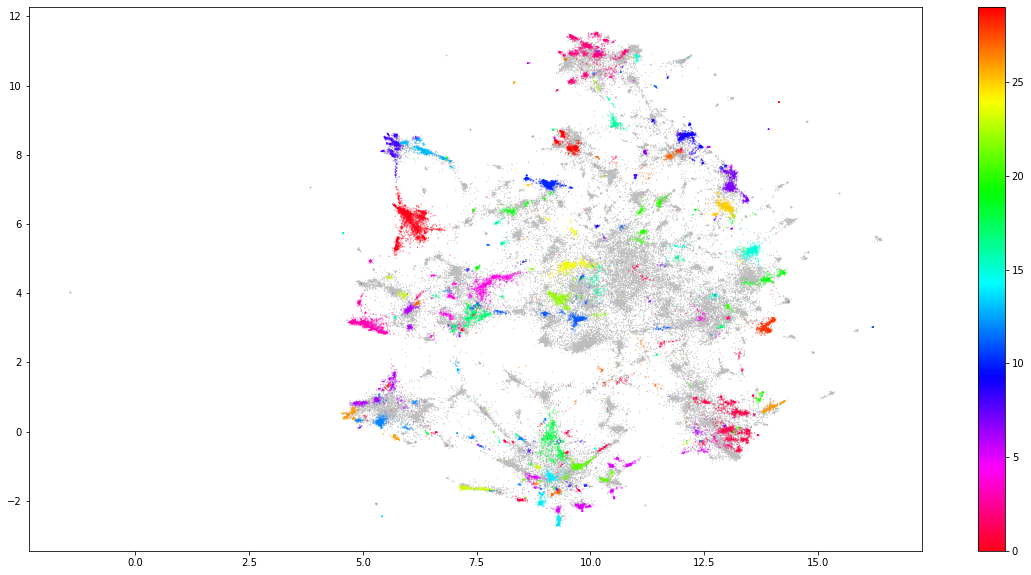

In [48]:
import matplotlib.pyplot as plt
# Visualize clusters
fig, ax = plt.subplots(figsize=(20, 10))
outliers = result.loc[result.labels == -1, :]
clustered = result.loc[result.labels != -1, :]
plt.scatter(outliers.x, outliers.y, color='#BDBDBD', s=0.05)
plt.scatter(clustered.x, clustered.y, c=clustered.labels, s=0.05, cmap='hsv_r')
plt.colorbar()

In [56]:
topic_model1.visualize_hierarchy()

In [59]:
topic_model1.get_topic(5)

[('pizza', 0.1311570630411415),
 ('cream', 0.06575569936969647),
 ('ice', 0.06528403281242172),
 ('steak', 0.037398311226879394),
 ('pasta', 0.03703950326080481),
 ('eat', 0.031738724833935666),
 ('candy', 0.03107035261862897),
 ('love', 0.029787471214004546),
 ('pie', 0.029349048827870927),
 ('spaghetti', 0.028694739710533816)]

## 1.3 Save 

In [44]:
topic_model1.save('./drive/MyDrive/Graduate Study/MSAI/AI6127/Project/topic_models/bertopic/model_wprob1.pth')

/usr/local/lib/python3.7/dist-packages/scipy/sparse/_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


In [49]:
chat_df.drop(columns=['embeddings']).to_csv('./drive/MyDrive/Graduate Study/MSAI/AI6127/Project/topic_models/bertopic/chat_df.csv')

In [55]:
topic_info.to_csv('./drive/MyDrive/Graduate Study/MSAI/AI6127/Project/topic_models/bertopic/topic_info.csv')

# 2. LDA

## 2.0 Data

In [67]:
import pandas as pd
import gensim
import gensim.corpora as corpora
import pyLDAvis.gensim_models
import nltk
nltk.download('stopwords')

from gensim.utils import simple_preprocess
from nltk.corpus import stopwords

n_topics=30

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning:

Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working



In [61]:
df = pd.read_csv("personality.csv")
chat_df = df[['chat']]
chat_df['chat'] = chat_df['chat'].apply(lambda row: row.split('\n'))
chat_df = chat_df.explode('chat')
chat_df = chat_df[chat_df.chat != '']

In [62]:
stop_words = stopwords.words('english')
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) 
             if word not in stop_words] for doc in texts]
             
data = chat_df['chat'].tolist()
data_words = list(sent_to_words(data))
data_words = remove_stopwords(data_words)
id2word = corpora.Dictionary(data_words)
corpus = [id2word.doc2bow(text) for text in data_words]

## 2.1 Model

In [64]:
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=n_topics,
                                       passes=10, random_state=42, workers=3)

In [72]:
lda_model.print_topics(30)

[(0,
  '0.125*"live" + 0.062*"sorry" + 0.056*"home" + 0.051*"mom" + 0.046*"hear" + 0.040*"hair" + 0.030*"stay" + 0.024*"look" + 0.019*"oh" + 0.017*"seen"'),
 (1,
  '0.238*"great" + 0.204*"time" + 0.049*"way" + 0.029*"spend" + 0.020*"definitely" + 0.018*"relaxing" + 0.012*"plan" + 0.012*"lot" + 0.011*"yes" + 0.010*"much"'),
 (2,
  '0.297*"work" + 0.049*"hard" + 0.036*"busy" + 0.032*"keep" + 0.020*"store" + 0.018*"son" + 0.016*"quite" + 0.015*"pet" + 0.015*"home" + 0.014*"short"'),
 (3,
  '0.082*"living" + 0.058*"parents" + 0.043*"something" + 0.040*"say" + 0.030*"might" + 0.029*"amazing" + 0.027*"lots" + 0.027*"write" + 0.026*"away" + 0.024*"sad"'),
 (4,
  '0.236*"today" + 0.081*"hi" + 0.063*"hello" + 0.044*"house" + 0.031*"small" + 0.030*"finished" + 0.026*"close" + 0.022*"dinner" + 0.017*"hey" + 0.016*"canada"'),
 (5,
  '0.217*"hi" + 0.135*"enjoy" + 0.060*"tell" + 0.042*"else" + 0.028*"days" + 0.022*"paint" + 0.018*"draw" + 0.018*"weather" + 0.016*"artist" + 0.015*"love"'),
 (6,
  '0.

## 2.2 Visualization

In [ ]:
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, dictionary=lda_model.id2word)

In [73]:
pyLDAvis.enable_notebook()
vis

PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
25    -0.088206 -0.153178       1        1  5.598813
23    -0.092111 -0.114194       2        1  4.107524
15     0.004154  0.158782       3        1  3.813671
13    -0.117798 -0.034395       4        1  3.800288
14    -0.008558  0.138443       5        1  3.769905
22    -0.095023 -0.038312       6        1  3.697211
28    -0.080983 -0.052259       7        1  3.681230
19    -0.040379 -0.067815       8        1  3.634509
20    -0.068035  0.050350       9        1  3.620384
10     0.069858  0.090941      10        1  3.600425
0      0.033529  0.156571      11        1  3.573781
26     0.011605  0.134411      12        1  3.556934
17    -0.029233 -0.079208      13        1  3.549465
2      0.025512  0.100960      14        1  3.448889
29    -0.030979  0.026749      15        1  3.394933
21    -0.047960  0.053256      16        1  3.379637
7     -0.061921 -0.007651      17        1  3.340418
12    -0.041807  0.034553      18        1  3.326331
8      0.000244 -0.106370      19        1  3.136512
1     -0.009622 -0.032337      20        1  3.095716
9     -0.090942 -0.137102      21        1  3.010746
27    -0.069783 -0.088687      22        1  2.931928
18    -0.042403  0.043652      23        1  2.877124
3     -0.020835  0.070616      24        1  2.828465
24     0.015204  0.070320      25        1  2.745555
6      0.113669  0.069519      26        1  2.684379
5      0.131036 -0.148247      27        1  2.582721
16    -0.016406  0.017093      28        1  2.523108
11     0.293849 -0.034901      29        1  2.427064
4      0.354325 -0.121558      30        1  2.262335, topic_info=        Term          Freq         Total Category  logprob  loglift
15      like  15052.000000  15052.000000  Default  30.0000  30.0000
65      good   7678.000000   7678.000000  Default  29.0000  29.0000
150     work   6177.000000   6177.000000  Default  28.0000  28.0000
104    great   4440.000000   4440.000000  Default  27.0000  27.0000
82      cool   4171.000000   4171.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
1331  longer     56.278938     57.221884  Topic30  -5.4912   3.7722
3         hi   1100.420986   4482.641903  Topic30  -2.5181   2.3843
212    hello    855.338737   3183.603866  Topic30  -2.7701   2.4745
436      hey    237.392984   1563.338934  Topic30  -4.0518   1.9039
3081  animal     67.061253    311.811441  Topic30  -5.3159   2.2520

[1207 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
2320     22  0.997016        able
1828     15  0.907109  absolutely
1828     20  0.090110  absolutely
2209      3  0.996795  accountant
1266     18  0.987918         act
...     ...       ...         ...
2553      7  0.988329    youngest
894      17  0.996513     youtube
1062      2  0.995823         yum
147       1  0.991314       yummy
2704      3  0.987018         zoo

[1699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[26, 24, 16, 14, 15, 23, 29, 20, 21, 11, 1, 27, 18, 3, 30, 22, 8, 13, 9, 2, 10, 28, 19, 4, 25, 7, 6, 17, 12, 5])

## 2.3 Save

In [74]:
lda_model.save('./drive/MyDrive/Graduate Study/MSAI/AI6127/Project/topic_models/lda/model')

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

/usr/local/lib/python3.7/dist-packages/smart_open/smart_open_lib.py:494: DeprecationWarning:

This function is deprecated.  See https://github.com/RaRe-Technologies/smart_open/blob/develop/MIGRATING_FROM_OLDER_VERSIONS.rst for more information

